필요한 모듈을 임포트한다.

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle # 이미지 데이터를 읽어들이기 위한 모듈

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

데이터 파일 'Lines.data'에서 이미지와 라벨 데이터를 읽어들인다.

변수 images와 label에는 각각 이미지 데이터와 이미지의 종류를 나타내는 라벨 데이터리스트가 저장된다.

이미지 데이터는 28X28=784개의 픽셀의 농도를 나타내는 수치가 나열된 1차원 리스트 (Numpy array object)이다.

총 90장의 이미지 데이터가 있다.

In [22]:
with open('/content/Lines.data', 'rb') as file:
    images, labels = pickle.load(file)

이미지 데이터 샘플을 출력한다.

40장의 이미지를 출력하고, 각각의 타이틀에 라벨값을 붙여 출력한다.

imshow의 옵션

https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html

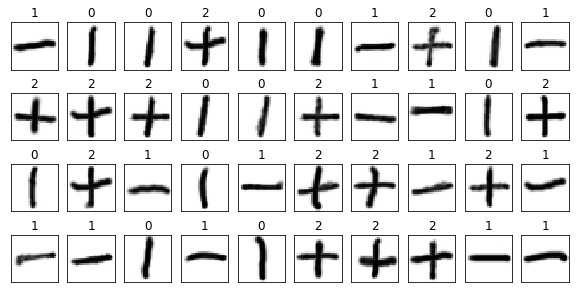

In [23]:
fig = plt.figure(figsize=(10,5))
for i in range(40):
    subplot = fig.add_subplot(4, 10, i+1)
    subplot.set_xticks([])  # 눈금 X
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))      # i번째 데이터의 라벨 출력
    subplot.imshow(images[i].reshape(28,28), vmin=0, vmax=1,    # 이미지 종류, 픽셀 크기, 픽셀 최소/최대값, 흑백, 
                   cmap=plt.cm.gray_r) # i번째 데이터 이미지 출력

필터 정보를 저장한 다차원 리스트를 만드는 함수를 준비한다.

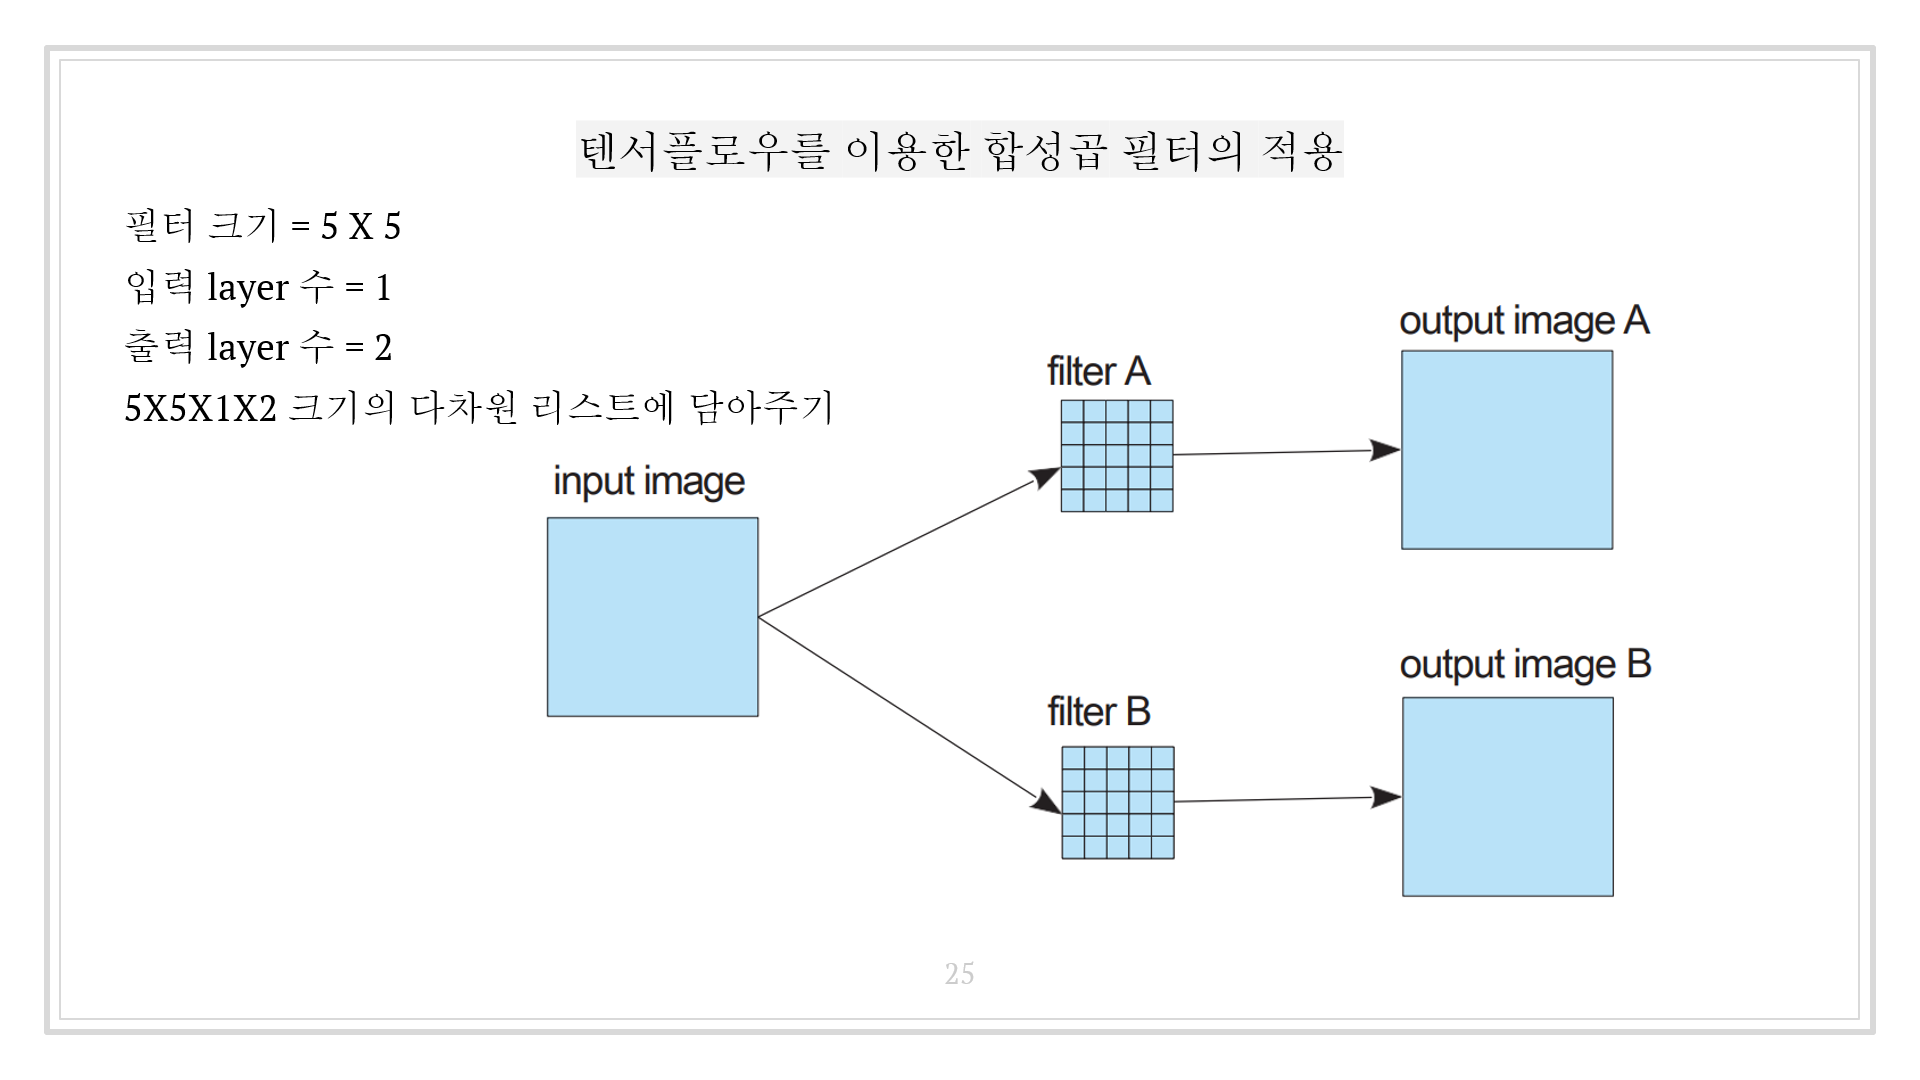

In [24]:
def edge_filter():
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0        # 계산 편의상 23으로 나눠주기.
                                              # 참고로 이렇게만 나눠도 브로드케스팅으로 각 요소 나눗셈
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5,5,1,2])        # filter를 담는 array
    filter_array[:,:,0,0] = filter0
    filter_array[:,:,0,1] = filter1

    return tf.constant(filter_array, dtype=tf.float32)

이미지 데이터에 필터를 적용하는 계산식을 준비한다.

- `tf.nn.conv2d` : 필터 적용.
  - 주로 `이미지 개수X이미지 크기(가로x세로)X레이어 개수` 크기의 다자원 리스트로 데이터 지정
- `stride` : 일정 간격으로 픽셀 추출, 이미지 크기를 작게하는 옵션. 
- `padding` : 이미지 끝부분에 필터 적용.

> stride, padding은 강의 자료 참고.

In [25]:
x = tf.placeholder(tf.float32, [None, 784]) # 28 X 28 = 784 입력값
x_image = tf.reshape(x, [-1,28,28,1])     # 이미지크기 28X28, 레이어 개수 1, 이미지 개수는 알아서 조정
                                          # -1: placeholder에 저장된 데이터 개수에 따라 적절하게 조정하라
W_conv = edge_filter()      # 미리 준비한 filter를 W_conv에 담기
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv,
                             strides=[1,1,1,1], padding='SAME')) # x-image에 대해 필터 W_conv 적용
                                                # tf.abs 에지 추출 필터에서는 결과가 음수일 경우 절대값

h_conv_cutoff = tf.nn.relu(h_conv-0.2)    # 결과를 좀 더 명확히 받아보기 위한 처리  
                                          # 농도가 0.2보다 작은 것들은 모두 0으로 처리하라

# 풀링 계층에 대한 처리. 추후 배울 예정
# stride, padding - 강의자료 참고
h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

이미지 종류를 판별할 때 중요한 것은 **내가 찾고자 하는 특징이 있는지 여부**이지, 상세한 내용은 무시해도 된다.

따라서 필터 결과의 가시적인 결과 반영을 위해 일부러 해상도를 낮춰 상세 정보를 제거하게 되는데, 이 처리를 해 주는 계층이 풀링 계층의 역할

`tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')`
: `ksize` 에 지정된 크기의 블록을 `strides` 만큼 이동시키며 블럭 내에 있는 픽셀의 최댓값으로 치환해준다.

세션을 준비하고 Variable을 초기화한다.

In [26]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

최초 9개의 이미지 데이터에 대해 합성곱 필터를 적용한 결과를 계산한다.

> w_conv(필터)와 h_conv_cutoff(적용 이후)를 평가한다

In [27]:
filter_vals, conv_vals = sess.run([W_conv, h_conv_cutoff],
                                  feed_dict={x:images[:9]})

얻어진 결과를 이미지로 출력한다.

여기서는 원본 이미지와 두 종류의 필터를 적용한 결과를 각각 출력하고 있다.

왼쪽은 적용한 필터를 이미지화한 것이다.

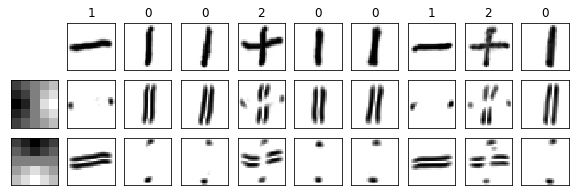

In [28]:
fig = plt.figure(figsize=(10,3))

# 두 개의 필터를 이미지 표시한다
for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, )

# 원본 이미지와 두 필터를 적용한 각각의 결과를 출력
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), cmap=plt.cm.gray_r)
    
    # conv_vals에 h_conv_cutoff 저장됨 : 이미지 개수 X 이미지크기(가로X세로) X 출력 layer 개수 array
    # conv_vals[i,:,:,0] -> i번째 이미지에 대한 첫 번째 필터 적용 결과
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,0],cmap=plt.cm.gray_r)
    
    # conv_vals[i,:,:,1] -> i번째 이미지에 대한 두 번째 필터 적용 결과
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,1], cmap=plt.cm.gray_r)

위 데이터 결과에서 위 쪽 필터는 가로 방향의 직선이 제거되고 세로방향의 직선에 대해서는 양쪽 edge부분이 출력된다. 가로방향에 대해서도 양쪽 끝에 있는 에지부분은 사라지지않고 남아있다. 

> 아래 필터는 방향만 그대로 반대

## 풀링 계층을 이용한 이미지 축소

필터 적용 후에 풀링 계층을 적용한 결과를 얻는다.

> `h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME'`

In [29]:
# pool_vals : 이미지 개수 X 이미지 크기(세로 X 가로) X 출력 layer 개수 형식의 array object 할당
pool_vals = sess.run(h_pool, feed_dict={x:images[:9]})

얻어진 결과를 이미지로 출력한다.

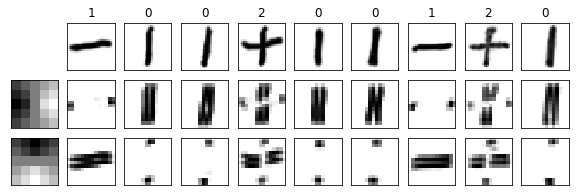

In [30]:
fig = plt.figure(figsize=(10,3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    # conv_vals -> pool_vals
    subplot.imshow(pool_vals[i,:,:,0],cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    # conv_vals -> pool_vals
    subplot.imshow(pool_vals[i,:,:,1], cmap=plt.cm.gray_r)

> 참고

cmap

https://frhyme.github.io/python-lib/matplotlib_extracting_color_from_cmap/